In [47]:
import numpy as np
import pandas as pd 
from shapely.wkt import loads
from shapely.geometry import Point
import geopandas as gpd
import itertools
import sys
sys.path.insert(0, '/Users/bingyu')
from sp import interface
import matplotlib.pyplot as plt

In [74]:
class Trains():
    def __init__(self):
        self.trains_df = None
        self.train_id = None ### use GTFS trip_id
        self.schedule = None ### concise dataframe of the (time, location)
        self.capacity = 100
        self.current_occupancy = None
        
    def add_schedule(self, schedule_df):
        
        ### add train_id (GTFS trip_id)
        self.train_id = schedule_df.iloc[0]['trip_id']
        
        ### add schedule (station arrival and departure time)
        ### begin with cleaning the GTFS data (schedule df)
        schedule_df['arrival_time'] = schedule_df['arrival_time'].apply(
            lambda x: 3600*int(x.split(':')[0]) + 60*int(x.split(':')[1]) +
            int(x.split(':')[2]))
        schedule_df['departure_time'] = schedule_df['departure_time'].apply(
            lambda x: 3600*int(x.split(':')[0]) + 60*int(x.split(':')[1]) +
            int(x.split(':')[2]))
        ### add 30 seconds dwell time at stop if train arrival time = train departure time in GTFS
        schedule_df['departure_time'] = np.where(schedule_df['arrival_time']==schedule_df['departure_time'],
                                                schedule_df['departure_time']+30, schedule_df['departure_time'])
        
        ### convert the cleaned GTFS data (schedule_df) into class attribute (self.schedule)
        schedule_list = []
        for row in schedule_df.itertuples():
            schedule_list.append((getattr(row, 'arrival_time'), 'stop', 
                                  getattr(row, 'route_stop_id')))
            schedule_list.append((getattr(row, 'departure_time'), 'on_link',
                                  '{}-{}'.format(getattr(row, 'route_stop_id'), 
                                                 getattr(row, 'next_route_stop_id'))))
        self.schedule = pd.DataFrame(schedule_list, columns=['time', 'status', 'location'])
        self.schedule['next_time'] = self.schedule['time'].shift(-1)
        self.schedule = self.schedule[['time', 'next_time', 'status', 'location']]
        
    def update_location_occupancy(self, t):
        self.schedule['current_location'] = np.where(
            self.schedule['time']>t, 'future', np.where(
            self.schedule['next_time']>t, 'current', 'past'))
        
class Travelers():
    def __init__(self, od_df):
        self.travelers_df = od_df[['traveler_id', 'origin_nid', 'destin_nid', 'departure_time']].copy()
        self.travelers_paths = dict() ### graph path
        self.travelers_key_stops = dict() ### boarding, alignthing, transfering key stops
       
    def initial_status(self, station_id_nm_dict):
        ### initialize traveler_df
        self.travelers_df['traveler_status'] = 'platform'
        self.travelers_df['association'] = self.travelers_df['origin_nid'].map(station_id_nm_dict)
        try:
            self.travelers_df['next_station'] = self.travelers_df.apply(
                lambda x: self.travelers_key_stops[x['traveler_id']][x['association']], axis=1)
        except KeyError:
            print(self.travelers_key_stops)
    
    def find_routes(self, network_g, station_id_nm_dict):
        ### find paths using Dijkstra's algorithm
        for traveler in self.travelers_df.itertuples():
            traveler_origin = getattr(traveler, 'origin_nid')
            traveler_destin = getattr(traveler, 'destin_nid')
            sp = network_g.dijkstra(traveler_origin, traveler_destin)
            sp_dist = sp.distance(traveler_destin)

            if sp_dist > 10e7:
                sp.clear()
                traveler_path = []
                key_stops = []
                print(traveler)
            else:
                sp_path = sp.route(traveler_destin)
                traveler_path = [
                    station_id_nm_dict[start_nid] for (start_nid, end_nid) in sp_path] + [
                    station_id_nm_dict[traveler_destin]]
                sp.clear()

                key_stops = []
                current_route = None ### current line number/name
                for stop in traveler_path[:-1]: ### always append the last element, so no need to iterate through
                    new_route = stop.split('-')[0]
                    if new_route != current_route:
                        key_stops.append(stop)
                        current_route = new_route
                key_stops.append(traveler_path[-1])

            self.travelers_paths[getattr(traveler, 'traveler_id')] = traveler_path
            self.travelers_key_stops[getattr(traveler, 'traveler_id')] = {
                xy[0]:xy[1] for xy in zip(key_stops, key_stops[1:])}
            
    def find_next_station(self, x):
        try:
            next_station = self.travelers_key_stops[x['traveler_id']][x['association']]
        except KeyError:
            next_station = None
        return next_station

    def traveler_update(self, train_id, train_status, train_location, t):

        ### aboard
        aboard_travelers = (
            self.travelers_df['departure_time']<t) & (
            self.travelers_df['traveler_status']=='platform') & (
            self.travelers_df['association']==train_location)
        self.travelers_df['association'] = np.where(
            aboard_travelers, train_id, self.travelers_df['association'])
        self.travelers_df['traveler_status'] = np.where(
            aboard_travelers, 'train', self.travelers_df['traveler_status'])

        ### alight
        alight_travelers = (
            self.travelers_df['traveler_status']=='train') & (
            self.travelers_df['association']==train_id) & (
            self.travelers_df['next_station']==train_location)
        self.travelers_df['association'] = np.where(
            alight_travelers, train_location, self.travelers_df['association'])
        self.travelers_df['traveler_status'] = np.where(
            alight_travelers, 'platform', self.travelers_df['traveler_status'])
        ### all travelers
        self.travelers_df['next_station'] = self.travelers_df.apply(
            lambda x: self.find_next_station(x) , axis=1)

### Process GTFS schedules
Need the following tables:
 * stop_times.txt: schedule info
 * trips.txt: map trip_id to route_id
 * stops.txt: get stop coordinates (for visualization)

In [39]:
### process_schedule (gtfs)
### process individual trains
stop_times_table = pd.read_csv('example_bart_google_transit_20211101_20220213_v2/stop_times.txt')
stop_times_table = stop_times_table[['trip_id', 'arrival_time', 'departure_time', 'stop_id']]

### assign a route code to individual trains
trips_table = pd.read_csv('example_bart_google_transit_20211101_20220213_v2/trips.txt')
stop_times_table = pd.merge(stop_times_table, trips_table[['trip_id', 'route_id']],
                           how='left', on='trip_id')
### assign a route code to individual stops
stop_times_table['route_stop_id'] = stop_times_table.apply(lambda x: 
                                                           '{}-{}'.format(x['route_id'], x['stop_id']), axis=1)

### assign locations to individual stations
stops_table = pd.read_csv('example_bart_google_transit_20211101_20220213_v2/stops.txt')
stop_times_table = pd.merge(stop_times_table, 
                            stops_table[['stop_id', 'stop_lon', 'stop_lat']], how='left', on='stop_id')
### shift line for better plotting
route_seq_dict = dict()
seq_id = 0
for route_id, _ in stop_times_table.sort_values(by='route_id', ascending=True).groupby('route_id'):
    route_seq_dict[route_id] = seq_id
    seq_id += 1
stop_times_table = gpd.GeoDataFrame(stop_times_table, crs='epsg:4326', 
                                   geometry=[Point(xy) for xy in zip(stop_times_table.stop_lon, 
                                                                     stop_times_table.stop_lat)])
stop_times_table = stop_times_table.to_crs(3857)
stop_times_table['stop_x'] = stop_times_table.geometry.centroid.x + 10*stop_times_table['route_id'].map(route_seq_dict)
stop_times_table['stop_y'] = stop_times_table.geometry.centroid.y + 10*stop_times_table['route_id'].map(route_seq_dict)
stop_times_table['geometry'] = [Point(xy) for xy in zip(stop_times_table.stop_x, stop_times_table.stop_y)]
stop_times_table = stop_times_table.to_crs(4326)
stop_times_table['stop_lon'] = stop_times_table.geometry.centroid.x
stop_times_table['stop_lat'] = stop_times_table.geometry.centroid.y

### make list of trains
list_of_trains = []
### make list of links for making graph
list_of_links = []

for trip_id, trip_schedule in stop_times_table.groupby('trip_id'):
    
    ### link to next stops
    trip_schedule['next_route_stop_id'] = trip_schedule['route_stop_id'].shift(-1)
    trip_schedule['next_stop_lon'] = trip_schedule['stop_lon'].shift(-1)
    trip_schedule['next_stop_lat'] = trip_schedule['stop_lat'].shift(-1)
    
    ### initiate trains
    train = Train()
    train.add_schedule(trip_schedule)
    list_of_trains.append(train)
    
    ### add network links
    list_of_links.append(trip_schedule[['route_stop_id', 'next_route_stop_id', 
                                        'stop_lon', 'stop_lat', 'next_stop_lon', 'next_stop_lat']])

/var/folders/ll/j_5ytxr96s91ykbn8skgr1hw0000gn/T/ipykernel_66717/4285243138.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stop_times_table['stop_lon'] = stop_times_table.geometry.centroid.x
/var/folders/ll/j_5ytxr96s91ykbn8skgr1hw0000gn/T/ipykernel_66717/4285243138.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stop_times_table['stop_lat'] = stop_times_table.geometry.centroid.y


In [53]:
### process network
all_links = pd.concat(list_of_links).drop_duplicates(subset=['route_stop_id', 'next_route_stop_id'])
all_links = all_links.loc[~pd.isnull(all_links['next_route_stop_id'])]

### create nodes
all_nodes = pd.DataFrame(np.vstack(
    [all_links[['route_stop_id', 'stop_lon', 'stop_lat']].values,
     all_links[['next_route_stop_id', 'next_stop_lon', 'next_stop_lat']].values]),
    columns=['route_stop_id', 'stop_lon', 'stop_lat'])
all_nodes = all_nodes.drop_duplicates(subset=['route_stop_id'])
all_nodes['node_id'] = np.arange(all_nodes.shape[0])
all_nodes = gpd.GeoDataFrame(
    all_nodes, crs='epsg:4326', 
    geometry=[Point(xy) for xy in zip(all_nodes.stop_lon, all_nodes.stop_lat)])
station_nm_id_dict = {getattr(row, 'route_stop_id'): getattr(
    row, 'node_id') for row in all_nodes.itertuples()}
station_id_nm_dict = {getattr(row, 'node_id'): getattr(
    row, 'route_stop_id') for row in all_nodes.itertuples()}

### add transfer links
all_nodes['stop_id'] = all_nodes['route_stop_id'].apply(lambda x: x.split('-')[1])
transfer_links = []
for stop_id, grp in all_nodes.groupby('stop_id'):
    for (stop1, stop2) in list(itertools.permutations(grp.to_dict('records'), 2)):
        transfer_links.append([stop1['route_stop_id'], stop2['route_stop_id'], 
                               stop1['stop_lon'], stop1['stop_lat'], stop2['stop_lon'], stop2['stop_lat']])
transfer_links_df = pd.DataFrame(transfer_links, columns=['route_stop_id', 'next_route_stop_id',
                                                         'stop_lon', 'stop_lat', 'next_stop_lon', 'next_stop_lat'])
all_links = pd.concat([all_links, transfer_links_df])

### map stop names to node_ids
all_links['start_nid'] = all_links['route_stop_id'].map(station_nm_id_dict)
all_links['end_nid'] = all_links['next_route_stop_id'].map(station_nm_id_dict)
all_links['initial_weight'] = 1.0
all_links['geometry'] = all_links.apply(
    lambda x: 'LINESTRING({} {}, {} {})'.format(
        x['stop_lon'], x['stop_lat'], x['next_stop_lon'], x['next_stop_lat']
    ), axis=1)
all_links = gpd.GeoDataFrame(all_links, crs='epsg:4326', geometry=all_links['geometry'].map(loads))
all_links = all_links[[
    'route_stop_id', 'next_route_stop_id', 'start_nid', 'end_nid',
    'initial_weight', 'geometry']]

display(all_nodes.head(3))
display(all_links.head(2))
all_links.to_csv('example_links.csv', index=False)
all_nodes.to_csv('example_nodes.csv', index=False)

### geometry dictionary
station_locations = {
    getattr(row, 'route_stop_id'): getattr(row, 'geometry') for row in all_nodes.itertuples()}
link_sections = {
    '{}-{}'.format(getattr(row, 'route_stop_id'), getattr(row, 'next_route_stop_id')):
    getattr(row, 'geometry').interpolate(0.2, 0.3) for row in all_links.itertuples()}

### create graph for shortest path calculations
network_g = interface.from_dataframe(all_links, 'start_nid', 'end_nid', 'initial_weight')

,route_stop_id,stop_lon,stop_lat,node_id,geometry,stop_id
0,1-CONC,-122.029072,37.973757,0,POINT (-122.02907 37.97376),CONC
1,1-PHIL,-122.055971,37.928434,1,POINT (-122.05597 37.92843),PHIL
2,1-WCRK,-122.067327,37.905791,2,POINT (-122.06733 37.90579),WCRK


,route_stop_id,next_route_stop_id,start_nid,end_nid,initial_weight,geometry
38967,1-CONC,1-PHIL,0,1,1.0,"LINESTRING (-122.02907 37.97376, -122.05597 37..."
38968,1-PHIL,1-WCRK,1,2,1.0,"LINESTRING (-122.05597 37.92843, -122.06733 37..."


In [146]:
### create od
np.random.seed(0)
num_travelers = 100
#traveler_origins = np.random.choice(all_nodes['node_id'], num_travelers)
#traveler_destins = np.random.choice(all_nodes['node_id'], num_travelers)
traveler_origins = [9]
traveler_destins = [22]
od_df = pd.DataFrame({
    'origin_nid': traveler_origins, 'destin_nid': traveler_destins})
od_df = od_df.loc[od_df['origin_nid']!=od_df['destin_nid']].copy()
od_df['traveler_id'] = np.arange(od_df.shape[0])
od_df['departure_time'] = np.random.randint(25980, 26980, od_df.shape[0])
display(od_df.head(2))

### create instance
travelers = Travelers(od_df)
travelers.find_routes(network_g, station_id_nm_dict)
travelers.initial_status(station_id_nm_dict)

,origin_nid,destin_nid,traveler_id,departure_time
0,9,22,0,26664


In [156]:
print(travelers.travelers_paths[0])
print(travelers.travelers_key_stops[0])
list_of_trains[0].schedule.sort_values(by='time', ascending=True)

['1-WOAK', '1-EMBR', '1-MONT', '1-POWL', '1-CIVC', '1-16TH', '1-24TH', '1-GLEN', '1-BALB', '1-DALY', '1-COLM', '1-SSAN', '1-SBRN', '1-SFIA']
{'1-WOAK': '1-SFIA'}


,time,next_time,status,location,current_location
0,25980,26040.0,stop,1-CONC,past
1,26040,26340.0,on_link,1-CONC-1-PHIL,past
2,26340,26370.0,stop,1-PHIL,past
3,26370,26460.0,on_link,1-PHIL-1-WCRK,past
4,26460,26520.0,stop,1-WCRK,past
5,26520,26760.0,on_link,1-WCRK-1-LAFY,past
6,26760,26790.0,stop,1-LAFY,past
7,26790,27060.0,on_link,1-LAFY-1-ORIN,past
8,27060,27090.0,stop,1-ORIN,past
9,27090,27360.0,on_link,1-ORIN-1-ROCK,past


In [157]:
for t in range(27864, 28684, 20):
    for train in list_of_trains:
        ### update train location
        train.update_location_occupancy(t)
        train_id = train.train_id
        try:
            train_status = train.schedule.loc[
                train.schedule['current_location']=='current', 'status'].iloc[0]
            train_location = train.schedule.loc[
                train.schedule['current_location']=='current', 'location'].iloc[0]
        except IndexError:
            continue
        #print(t, train_id, train_status, train_location)
        
        ### update traveler_location
        if train_status == 'stop':
            print(t, train_id, train_status, train_location)
            travelers.traveler_update(train_id, train_status, train_location, t)
            display(travelers.travelers_df)
        break
#train.schedule.head()

27864 938041 stop 1-19TH


,traveler_id,origin_nid,destin_nid,departure_time,traveler_status,association,next_station
0,0,9,22,26664,train,938041,None


27904 938041 stop 1-12TH


,traveler_id,origin_nid,destin_nid,departure_time,traveler_status,association,next_station
0,0,9,22,26664,train,938041,None


27924 938041 stop 1-12TH


,traveler_id,origin_nid,destin_nid,departure_time,traveler_status,association,next_station
0,0,9,22,26664,train,938041,None


27944 938041 stop 1-12TH


,traveler_id,origin_nid,destin_nid,departure_time,traveler_status,association,next_station
0,0,9,22,26664,train,938041,None


28204 938041 stop 1-WOAK


,traveler_id,origin_nid,destin_nid,departure_time,traveler_status,association,next_station
0,0,9,22,26664,train,938041,None


28224 938041 stop 1-WOAK


,traveler_id,origin_nid,destin_nid,departure_time,traveler_status,association,next_station
0,0,9,22,26664,train,938041,None


28624 938041 stop 1-EMBR


,traveler_id,origin_nid,destin_nid,departure_time,traveler_status,association,next_station
0,0,9,22,26664,train,938041,None


28644 938041 stop 1-EMBR


,traveler_id,origin_nid,destin_nid,departure_time,traveler_status,association,next_station
0,0,9,22,26664,train,938041,None


In [158]:
### get train position
train_locations=[]
for train in list_of_trains:
    train_current_row = train.schedule[train.schedule['current_location']=='current']
    if train_current_row.shape[0]==0:
        continue
    train_id = train.train_id
    train_current_row_locations = train_current_row['location'].iloc[0]
    train_current_row_status = train_current_row['status'].iloc[0]
    if train_current_row_status == 'stop':
        train_current_row_geometry = station_locations[train_current_row_locations]
    elif train_current_row_status == 'on_link':
        train_current_row_geometry = link_sections[train_current_row_locations]
    else:
        train_current_row_geometry = None
    train_locations.append([
        train_id, train_current_row_locations, train_current_row_geometry
    ])
train_locations_df = pd.DataFrame(train_locations, columns=['train_id', 'location', 'geometry'])
train_locations_df = gpd.GeoDataFrame(train_locations_df, crs='epsg:4326', geometry=train_locations_df['geometry'])

In [159]:
### get traveler locations
traveler_locations_df = travelers.travelers_df.groupby(
    ['traveler_status', 'association']).size().to_frame(
    name='num_travelers').reset_index(drop=False)
traveler_locations_df['association'] = traveler_locations_df['association'].astype(str)
traveler_locations_df = pd.merge(
    traveler_locations_df, all_nodes[['route_stop_id', 'geometry']], 
    how='left', left_on='association', right_on='route_stop_id')
train_locations_df_tmp = train_locations_df.copy()
train_locations_df_tmp['train_id'] = train_locations_df_tmp['train_id'].astype(str)
traveler_locations_df = pd.merge(
    traveler_locations_df, train_locations_df_tmp[['train_id', 'geometry']], 
    how='left', left_on='association', right_on='train_id')
traveler_locations_df['geometry'] = np.where(pd.isnull(traveler_locations_df['geometry_x']), 
                                            traveler_locations_df['geometry_y'],
                                            traveler_locations_df['geometry_x'])
traveler_locations_df = traveler_locations_df[['association', 'num_travelers', 'geometry']]
traveler_locations_df = gpd.GeoDataFrame(traveler_locations_df, crs='epsg:4326', 
                                         geometry=traveler_locations_df['geometry'])
display(traveler_locations_df.tail())

,association,num_travelers,geometry
0,938041,1,POINT (-122.39795 37.79204)


<AxesSubplot:>

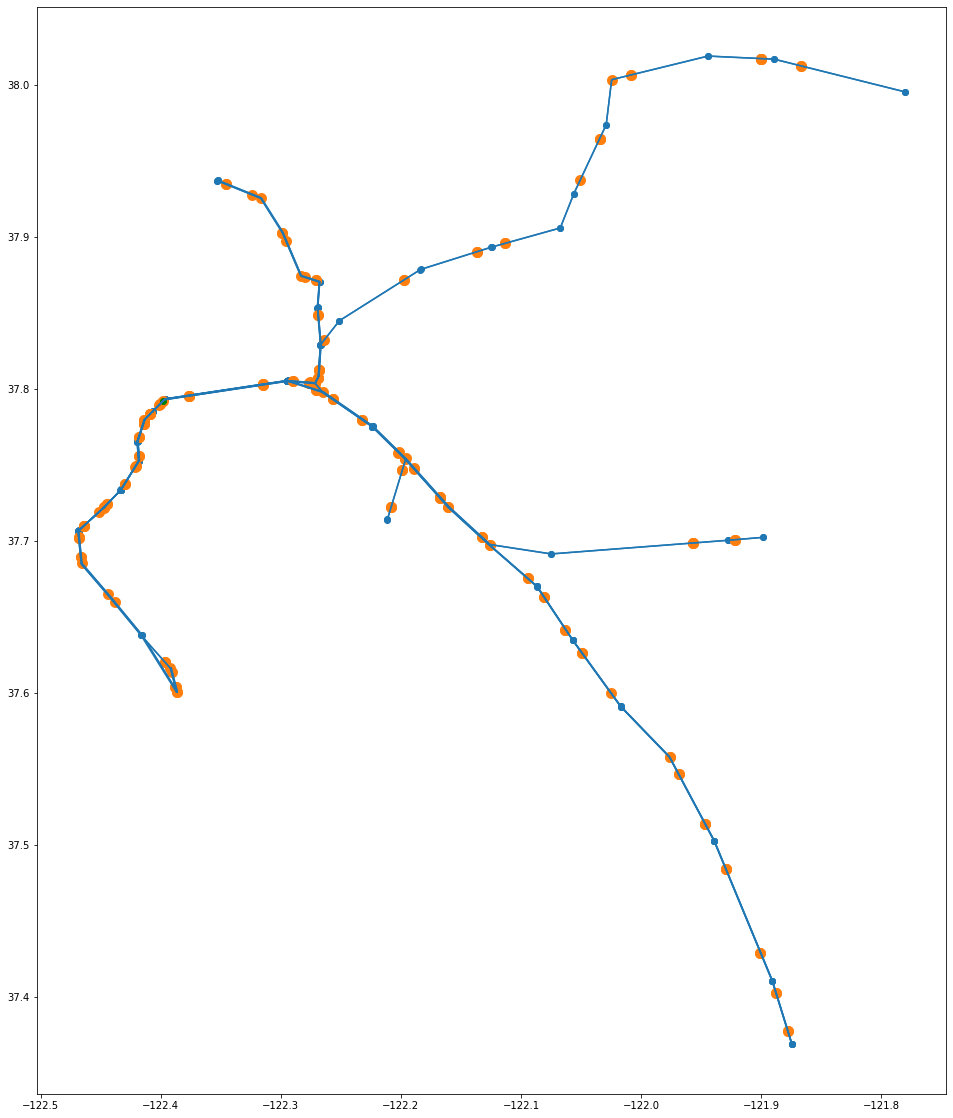

In [160]:
fig, ax = plt.subplots(figsize=(20, 20))
all_links.plot(ax=ax)
all_nodes.plot(ax=ax)
train_locations_df.plot(ax=ax, lw=5)
traveler_locations_df.plot(ax=ax, lw=traveler_locations_df['num_travelers'],
                          c='green')